# 1. Setup

In [1]:
!pip install librosa soundfile numpy

In [2]:
!pip install kagglehub

In [3]:
!pip install IPython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 31.7 MB/s eta 0:00:00


In [4]:
# Required Libraries
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import kagglehub
import os
import librosa
import soundfile as sf
from pathlib import Path
from collections import defaultdict
import IPython.display as ipd
from sklearn.model_selection import train_test_split
import re

# 2. Understanding the Data
We load dataset

In [5]:
# Download latest version
path = kagglehub.dataset_download("vjcalling/speaker-recognition-audio-dataset")

print("Path to dataset files:", path)

100%|██████████| 3.64G/3.64G [00:51<00:00, 76.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/vjcalling/speaker-recognition-audio-dataset/versions/1


In [6]:
# First, let's explore the dataset structure
def explore_dataset(dataset_path):
    """
    Explore the structure of the dataset
    """
    print("=" * 60)
    print("DATASET STRUCTURE")
    print("=" * 60)

    # List all files and folders
    for root, dirs, files in os.walk(dataset_path):
        level = root.replace(dataset_path, '').count(os.sep)
        indent = ' ' * 2 * level
        print(f'{indent}{os.path.basename(root)}/')

        # Show first few files in each directory
        sub_indent = ' ' * 2 * (level + 1)
        for file in files[:5]:  # Show only first 5 files
            print(f'{sub_indent}{file}')
        if len(files) > 5:
            print(f'{sub_indent}... and {len(files) - 5} more files')

    # Count audio files
    audio_extensions = ['.wav', '.mp3', '.flac', '.m4a']
    audio_files = []
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if any(file.lower().endswith(ext) for ext in audio_extensions):
                audio_files.append(os.path.join(root, file))

    print(f"\nTotal audio files found: {len(audio_files)}")

    # Sample a few files to check duration
    if audio_files:
        print("\n" + "=" * 60)
        print("SAMPLE AUDIO FILES INFO")
        print("=" * 60)
        for i, audio_file in enumerate(audio_files[:3]):
            try:
                audio, sr = librosa.load(audio_file, sr=16000, duration=1)
                duration = librosa.get_duration(path=audio_file)
                print(f"\nFile {i+1}: {os.path.basename(audio_file)}")
                print(f"  Duration: {duration:.2f} seconds")
                print(f"  Sample rate: {sr} Hz")
            except Exception as e:
                print(f"\nFile {i+1}: {os.path.basename(audio_file)}")
                print(f"  Error: {e}")

    return audio_files

In [7]:
# Run the exploration and extraction
dataset_path = path
audio_files = explore_dataset(dataset_path)

DATASET STRUCTURE
1/
  50_speakers_audio_data/
    Speaker0047/
      Speaker0047_025.wav
      Speaker0047_014.wav
      Speaker0047_001.wav
      Speaker0047_012.wav
      Speaker0047_032.wav
      ... and 29 more files
    Speaker0044/
      Speaker0044_029.wav
      Speaker0044_008.wav
      Speaker0044_004.wav
      Speaker0044_030.wav
      Speaker0044_020.wav
      ... and 32 more files
    Speaker0039/
      Speaker0039_037.wav
      Speaker0039_018.wav
      Speaker0039_033.wav
      Speaker0039_004.wav
      Speaker0039_007.wav
      ... and 46 more files
    Speaker0049/
      Speaker0049_021.wav
      Speaker0049_032.wav
      Speaker0049_000.wav
      Speaker0049_009.wav
      Speaker0049_045.wav
      ... and 45 more files
    Speaker_0019/
      Speaker_0019_00019.wav
      Speaker_0019_00025.wav
      Speaker_0019_00004.wav
      Speaker_0019_00017.wav
      Speaker_0019_00032.wav
      ... and 28 more files
    Speaker0050/
      Speaker0050_018.wav
      Speaker0050_0

# 3. Pre-Processing the Data
> We have to do multiple steps including extracting shorter segments of length of 1s, and reshaping the data to match the model input shape

In [9]:
def extract_segments_from_dataset(dataset_path, output_path, segments_per_file=10,
                                   segment_duration=1.0, strategy='evenly_spaced', max_speakers=10 , ending='00'):
    """
    Extract 1-second segments from audio files in the dataset

    Parameters:
    -----------
    dataset_path : str
        Path to the dataset
    output_path : str
        Path to save extracted segments
    segments_per_file : int
        Number of segments to extract per audio file
    segment_duration : float
        Duration of each segment in seconds
    strategy : str
        'evenly_spaced', 'random', or 'sequential'
    """
    os.makedirs(output_path, exist_ok=True)
    # List of speakers selected for the experiment - 5 female speakers and 5 male speakers
    valid_speakers = [7 , 10 , 16 , 40 , 50 , 0 , 8 ,  17 , 46 , 47]
    # Find all audio files
    audio_extensions = ['.wav', '.mp3', '.flac', '.m4a']
    audio_files = []
    for root, dirs, files in os.walk(dataset_path):
        # Extract the speaker number from the folder name (e.g., "Speaker_0023" → 23)
        folder_name = os.path.basename(root)

        # Try to extract the speaker number
        match = re.search(r'\d+', folder_name)
        if match:
            speaker_num = int(match.group())
            # Skip if not a valid speaker
            if speaker_num not in valid_speakers:
                continue
        else:
            # Skip folders without any number
            continue

        for file in files:
          if(len(audio_files) >= max_speakers):
            break
          filename_without_ext = os.path.splitext(file)[0]

          # Check if file ends with "_00000" and has audio extension
          if (filename_without_ext.endswith(ending) and
              any(file.lower().endswith(ext) for ext in audio_extensions)):
              audio_files.append(os.path.join(root, file))

    print(f"\nFound {len(audio_files)} audio files")
    print(f"Extracting {segments_per_file} segments of {segment_duration}s each...")
    print("=" * 60)

    extracted_count = 0

    for audio_file in audio_files:
      if(extracted_count >= max_speakers * segments_per_file):
        break
      else :
        try:
            # Load audio
            audio, sr = librosa.load(audio_file, sr=None)
            duration = len(audio) / sr
            segment_samples = int(segment_duration * sr)

            # Skip if audio is too short
            if duration < segment_duration:
                print(f"Skipped (too short): {os.path.basename(audio_file)} ({duration:.2f}s)")
                continue

            # Determine speaker/class from folder structure
            relative_path = os.path.relpath(audio_file, dataset_path)
            speaker_folder = os.path.dirname(relative_path)
            if speaker_folder == '':
                speaker_folder = 'unknown'

            # Create output folder for this speaker
            speaker_output = os.path.join(output_path, speaker_folder)
            os.makedirs(speaker_output, exist_ok=True)

            # Get base filename
            base_name = os.path.splitext(os.path.basename(audio_file))[0]

            # Determine start positions based on strategy
            max_segments = min(segments_per_file, int(duration / segment_duration))

            if strategy == 'random':
                max_start = len(audio) - segment_samples
                if max_segments <= max_start:
                    start_positions = np.random.choice(max_start, size=max_segments, replace=False)
                    start_positions = np.sort(start_positions)
                else:
                    start_positions = np.linspace(0, max_start, max_segments, dtype=int)

            elif strategy == 'evenly_spaced':
                usable_duration = len(audio) - segment_samples
                start_positions = np.linspace(0, usable_duration, max_segments, dtype=int)

            elif strategy == 'sequential':
                start_positions = [i * segment_samples for i in range(max_segments)]

            # Extract and save segments
            for idx, start_pos in enumerate(start_positions):
                segment = audio[start_pos:start_pos + segment_samples]

                output_filename = f"{base_name}_seg{idx+1:02d}.wav"
                output_filepath = os.path.join(speaker_output, output_filename)

                sf.write(output_filepath, segment, sr)
                extracted_count += 1

            print(f"✓ Processed: {os.path.basename(audio_file)} → {max_segments} segments")

        except Exception as e:
            print(f"✗ Error processing {os.path.basename(audio_file)}: {e}")

    print("=" * 60)
    print(f"\nExtraction complete!")
    print(f"Total segments extracted: {extracted_count}")
    print(f"Output saved to: {output_path}")


In [10]:
# Extract segments
print("\n" + "=" * 60)
print("EXTRACTING SEGMENTS")
print("=" * 60)

output_path = "extracted_1sec_segments"

extract_segments_from_dataset(
    dataset_path=dataset_path,
    output_path=output_path,
    segments_per_file=10,
    segment_duration=1.0,
    strategy='evenly_spaced',
    max_speakers=10
)


EXTRACTING SEGMENTS

Found 10 audio files
Extracting 10 segments of 1.0s each...
✓ Processed: Speaker0047_000.wav → 10 segments
✓ Processed: Speaker0050_000.wav → 10 segments
✓ Processed: Speaker0040_000.wav → 10 segments
✓ Processed: Speaker_0008_00000.wav → 10 segments
✓ Processed: Speaker_0000_00000.wav → 10 segments
✓ Processed: Speaker0046_000.wav → 10 segments
✓ Processed: Speaker_0007_00000.wav → 10 segments
✓ Processed: Speaker_0016_00000.wav → 10 segments
✓ Processed: Speaker_0017_00000.wav → 10 segments
✓ Processed: Speaker_0010_00000.wav → 10 segments

Extraction complete!
Total segments extracted: 100
Output saved to: extracted_1sec_segments


In [ ]:
# Extract segments
print("\n" + "=" * 60)
print("EXTRACTING SEGMENTS EXTENDED")
print("=" * 60)

output_path = "extracted_1sec_segments_extended"

extract_segments_from_dataset(
    dataset_path=dataset_path,
    output_path=output_path,
    segments_per_file=40,
    segment_duration=1.0,
    strategy='evenly_spaced',
    max_speakers=10
)


EXTRACTING SEGMENTS EXTENDED

Found 10 audio files
Extracting 40 segments of 1.0s each...
✓ Processed: Speaker0050_000.wav → 40 segments
✓ Processed: Speaker0046_000.wav → 40 segments
✓ Processed: Speaker0047_000.wav → 40 segments
✓ Processed: Speaker_0016_00000.wav → 40 segments
✓ Processed: Speaker_0000_00000.wav → 40 segments
✓ Processed: Speaker_0007_00000.wav → 40 segments
✓ Processed: Speaker_0010_00000.wav → 40 segments
✓ Processed: Speaker_0008_00000.wav → 40 segments
✓ Processed: Speaker0040_000.wav → 40 segments
✓ Processed: Speaker_0017_00000.wav → 40 segments

Extraction complete!
Total segments extracted: 400
Output saved to: extracted_1sec_segments_extended


In [12]:
# Extract segments for the testing dataset - combined TM architecture
print("\n" + "=" * 60)
print("EXTRACTING SEGMENTS TESTING")
print("=" * 60)

output_path = "extracted_1sec_segments_testing"

extract_segments_from_dataset(
    dataset_path=dataset_path,
    output_path=output_path,
    segments_per_file=10,
    segment_duration=1.0,
    strategy='evenly_spaced',
    max_speakers=10,
    ending='05'
)


EXTRACTING SEGMENTS TESTING

Found 10 audio files
Extracting 10 segments of 1.0s each...
✓ Processed: Speaker0047_005.wav → 10 segments
✓ Processed: Speaker0050_005.wav → 10 segments
✓ Processed: Speaker0040_005.wav → 10 segments
✓ Processed: Speaker_0008_00005.wav → 10 segments
✓ Processed: Speaker_0000_00005.wav → 10 segments
✓ Processed: Speaker0046_005.wav → 10 segments
✓ Processed: Speaker_0007_00005.wav → 10 segments
✓ Processed: Speaker_0016_00005.wav → 10 segments
✓ Processed: Speaker_0017_00005.wav → 10 segments
✓ Processed: Speaker_0010_00005.wav → 10 segments

Extraction complete!
Total segments extracted: 100
Output saved to: extracted_1sec_segments_testing


In [13]:
def load_segments_by_speaker(segments_folder, target_sr=16000):
    """
    Load audio segments organized by speaker into a 2D structure.

    Parameters:
    -----------
    segments_folder : str
        Path to folder containing extracted segments organized by speaker
    target_sr : int
        Target sample rate for all audio files

    Returns:
    --------
    segments_array : list of lists
        2D array where segments_array[i][j] is the j-th segment of speaker i
    speaker_names : list
        List of speaker names corresponding to each index
    """

    # Dictionary to store segments for each speaker
    speaker_segments = defaultdict(list)

    # Walk through the segments folder
    for speaker_folder in sorted(os.listdir(segments_folder)):
        speaker_path = os.path.join(segments_folder, speaker_folder)

        # Skip if not a directory
        if not os.path.isdir(speaker_path):
            continue

        print(f"Loading segments for: {speaker_folder}")

        # Get all audio files for this speaker
        audio_files = []
        for file in sorted(os.listdir(speaker_path)):
            if file.endswith(('.wav', '.mp3', '.flac', '.m4a')):
                audio_files.append(os.path.join(speaker_path, file))

        # Load each segment
        for audio_file in audio_files:
            try:
                # Load audio with specified sample rate
                audio, sr = librosa.load(audio_file, sr=target_sr)
                speaker_segments[speaker_folder].append(audio)

            except Exception as e:
                print(f"  Error loading {os.path.basename(audio_file)}: {e}")

        print(f"  Loaded {len(speaker_segments[speaker_folder])} segments")

    # Convert to 2D list structure
    speaker_names = sorted(speaker_segments.keys())
    segments_array = [speaker_segments[speaker] for speaker in speaker_names]

    return segments_array, speaker_names

In [14]:
def load_segments_as_numpy(segments_folder, target_sr=16000, pad=True):
    """
    Load audio segments into a proper numpy array with consistent shapes.

    Parameters:
    -----------
    segments_folder : str
        Path to folder containing extracted segments
    target_sr : int
        Target sample rate
    pad : bool
        If True, pad segments to the same length

    Returns:
    --------
    segments_array : numpy array
        Shape: (num_speakers, segments_per_speaker, segment_length)
    speaker_names : list
        List of speaker names
    """

    # First pass: load all segments
    temp_segments, speaker_names = load_segments_by_speaker(segments_folder, target_sr)

    # Determine dimensions
    num_speakers = len(temp_segments)
    segments_per_speaker = min(len(segments) for segments in temp_segments)

    if pad:
        # Find maximum segment length
        max_length = max(len(seg) for speaker_segs in temp_segments for seg in speaker_segs)
        segment_length = max_length
    else:
        # Use minimum segment length (will truncate)
        min_length = min(len(seg) for speaker_segs in temp_segments for seg in speaker_segs)
        segment_length = min_length

    print(f"\nArray dimensions:")
    print(f"  Number of speakers: {num_speakers}")
    print(f"  Segments per speaker: {segments_per_speaker}")
    print(f"  Segment length (samples): {segment_length}")
    print(f"  Duration per segment: {segment_length/target_sr:.2f} seconds")

    # Create numpy array
    segments_array = np.zeros((num_speakers, segments_per_speaker, segment_length))

    # Fill the array
    for i, speaker_segments in enumerate(temp_segments):
        for j in range(segments_per_speaker):
            segment = speaker_segments[j]

            if len(segment) >= segment_length:
                # Truncate if too long
                segments_array[i, j, :] = segment[:segment_length]
            else:
                # Pad if too short
                segments_array[i, j, :len(segment)] = segment

    return segments_array, speaker_names

In [15]:
def print_array_info(segments_array, speaker_names):
    """
    Print information about the segments array
    """
    print("\n" + "="*60)
    print("SEGMENTS ARRAY INFORMATION")
    print("="*60)

    if isinstance(segments_array, np.ndarray):
        print(f"Array shape: {segments_array.shape}")
        print(f"Array dtype: {segments_array.dtype}")
        print(f"Memory size: {segments_array.nbytes / (1024**2):.2f} MB")
    else:
        print(f"Number of speakers: {len(segments_array)}")
        print(f"Segments per speaker: {[len(segs) for segs in segments_array]}")

    print(f"\nSpeakers ({len(speaker_names)}):")
    for i, name in enumerate(speaker_names):
        if isinstance(segments_array, np.ndarray):
            num_segments = segments_array.shape[1]
        else:
            num_segments = len(segments_array[i])
        print(f"  [{i}] {name}: {num_segments} segments")

In [16]:
segments_folder = "extracted_1sec_segments/50_speakers_audio_data"

print("Loading segments into 2D array...")
print("="*60)

# Proper numpy array (all segments same length)
segments_numpy, speaker_names = load_segments_as_numpy(segments_folder, pad=True)
print_array_info(segments_numpy, speaker_names)

# Access examples:
print("\nAccess examples:")
print(f"  All segments from first speaker: segments_numpy[0]")
print(f"  Shape: {segments_numpy[0].shape}")
print(f"  Second speaker's third segment: segments_numpy[1, 2]")
print(f"  Shape: {segments_numpy[1, 2].shape}")
print(f"  All first segments from all speakers: segments_numpy[:, 0]")
print(f"  Shape: {segments_numpy[:, 0].shape}")

Loading segments into 2D array...
Loading segments for: Speaker0040
  Loaded 10 segments
Loading segments for: Speaker0046
  Loaded 10 segments
Loading segments for: Speaker0047
  Loaded 10 segments
Loading segments for: Speaker0050
  Loaded 10 segments
Loading segments for: Speaker_0000
  Loaded 10 segments
Loading segments for: Speaker_0007
  Loaded 10 segments
Loading segments for: Speaker_0008
  Loaded 10 segments
Loading segments for: Speaker_0010
  Loaded 10 segments
Loading segments for: Speaker_0016
  Loaded 10 segments
Loading segments for: Speaker_0017
  Loaded 10 segments

Array dimensions:
  Number of speakers: 10
  Segments per speaker: 10
  Segment length (samples): 16000
  Duration per segment: 1.00 seconds

SEGMENTS ARRAY INFORMATION
Array shape: (10, 10, 16000)
Array dtype: float64
Memory size: 12.21 MB

Speakers (10):
  [0] Speaker0040: 10 segments
  [1] Speaker0046: 10 segments
  [2] Speaker0047: 10 segments
  [3] Speaker0050: 10 segments
  [4] Speaker_0000: 10 segme

In [17]:
ipd.Audio(segments_numpy[6, 2], rate=16000)

> We extract MFCCs from the audio samples we have.
> We also extract the delta values as extra features for further experimentation.

In [18]:
def get_mfccs_with_labels(segments_array , num_samples , segment_length , n_mfccs=12):
  # Create numpy array
  # Create a structured numpy array with named fields
  segments_array_np = np.zeros(num_samples, dtype=[
    ('mfcc', np.float32, (n_mfccs , segment_length)),  # Audio signal
    ('label', np.int32)                         # Speaker label
  ])

  mfccs_array = []
  deltas_array = []      # First deltas
  delta2s_array = []     # Second deltas (delta-deltas)
  labels = []
  complete_mfcc_speaker = []

  # Fill the array
  k = 0
  for i, speaker_segments in enumerate(segments_array):
    speaker_mfccs = []
    min_val = 999999
    max_val = -999999
    for j in range(10):
      audio = speaker_segments[j]
      mfccs = librosa.feature.mfcc(y=audio , sr=16000 , n_mfcc=12 , n_fft=512, hop_length=82)
      # Extract deltas and delta-deltas
      deltas = librosa.feature.delta(mfccs)
      delta2s = librosa.feature.delta(mfccs, order=2)
      speaker_mfccs.append(mfccs)
      segments_array_np[k] = (mfccs, i)
      mfccs_array.append(mfccs.T)
      deltas_array.append(deltas.T)
      delta2s_array.append(delta2s.T)
      labels.append(i)
      k = k + 1

    complete_mfcc_speaker.append(np.concatenate(speaker_mfccs, axis=1))
  # Convert to numpy array to get shape
  complete_mfcc_array = np.array(complete_mfcc_speaker)
  print(f"Shape of all speakers MFCCs : {complete_mfcc_array.shape}")

  # Calculate min, max, median along axis 2 (the 1960 values)
  min_values = np.min(complete_mfcc_array, axis=2)      # Shape: (10, 12)
  max_values = np.max(complete_mfcc_array, axis=2)      # Shape: (10, 12)
  median_values = np.median(complete_mfcc_array, axis=2) # Shape: (10, 12)

  # Stack them together
  result = np.stack([min_values, max_values, median_values], axis=2)
  print(f"Result shape: {result.shape}")  # (10, 12, 3)

  # Convert lists to numpy arrays
  X = np.array(mfccs_array, dtype=np.float32)  # (100, 195, 12)
  X2 = np.array(deltas_array, dtype=np.float32)  # (100, 195, 12) - Deltas
  X3 = np.array(delta2s_array, dtype=np.float32) # (100, 195, 12) - Delta-deltas
  y = np.array(labels, dtype=np.int32)          # (100,)
  return segments_array_np , X , y , result , X2 , X3

In [25]:
def reshape_to_frame_level(X , X2 , X3 , y):
    """
    Reshape data so each frame becomes a separate sample.

    Parameters:
    -----------
    X : numpy array, shape (num_samples, n_frames, n_mfccs)
        Original data: (100, 195, 12)
    y : numpy array, shape (num_samples,)
        Original labels: (100,)

    Returns:
    --------
    X_frames : numpy array, shape (num_samples * n_frames, n_mfccs)
        Reshaped data: (19500, 12)
    y_frames : numpy array, shape (num_samples * n_frames,)
        Repeated labels: (19500,)
    """
    num_samples, n_frames, n_mfccs = X.shape

    # Reshape: flatten the first two dimensions
    X_frames = X.reshape(-1, n_mfccs)  # (100 * 196, 12) = (19600, 12)

    X2_frames = X2.reshape(-1, n_mfccs)  # (100 * 196, 12) = (19600, 12)

    X3_frames = X3.reshape(-1, n_mfccs)  # (100 * 196, 12) = (19600, 12)

    # Repeat each label n_frames times
    y_frames = np.repeat(y, n_frames)  # Each label repeated 196 times

    print(f"Original shape: {X.shape} → Frame-level shape: {X_frames.shape}")
    print(f"Original shape: {X2.shape} → Frame-level shape: {X2_frames.shape}")
    print(f"Original shape: {X3.shape} → Frame-level shape: {X3_frames.shape}")
    print(f"Original labels: {y.shape} → Frame-level labels: {y_frames.shape}")
    print(f"Total frame samples: {len(X_frames)}")

    return X_frames, y_frames , X2_frames , X3_frames


def verify_reshape(X_original, y_original, X_frames, y_frames, n_frames=196):
    """
    Verify that the reshape worked correctly
    """
    print("\n" + "="*60)
    print("VERIFICATION")
    print("="*60)

    # Check first sample's first frame
    print(f"\nOriginal first sample, first frame:")
    print(f"  X[0, 0, :] = {X_original[0, 0, :]}")
    print(f"  Label: {y_original[0]}")

    print(f"\nReshaped first frame:")
    print(f"  X_frames[0, :] = {X_frames[0, :]}")
    print(f"  Label: {y_frames[0]}")

    # Check they match
    if np.allclose(X_original[0, 0, :], X_frames[0, :]):
        print("  ✓ First frame matches!")

    # Check that labels are repeated correctly
    print(f"\nLabel distribution:")
    for speaker_id in range(10):
        count = np.sum(y_frames == speaker_id)
        expected = 10 * n_frames  # 10 samples per speaker * 196 frames
        print(f"  Speaker {speaker_id}: {count} frames (expected {expected})")

In [26]:
mfccs_dataset , X , Y , mfccs_speaker_feature_stats , X2 , X3 = get_mfccs_with_labels(segments_numpy , 100 , 196)
print(mfccs_dataset.shape)
print(X.shape)
print(Y.shape)

Shape of all speakers MFCCs : (10, 12, 1960)
Result shape: (10, 12, 3)
(100,)
(100, 196, 12)
(100,)


In [27]:
# Reshape to frame-level
X_frames, y_frames , X2_frames , X3_frames  = reshape_to_frame_level(X, X2 , X3 , Y)

# Verify
verify_reshape(X, Y, X_frames, y_frames)

print("\n" + "="*60)
print("SPLITTING INTO TRAIN/VAL/TEST")
print("="*60)

Original shape: (100, 196, 12) → Frame-level shape: (19600, 12)
Original shape: (100, 196, 12) → Frame-level shape: (19600, 12)
Original shape: (100, 196, 12) → Frame-level shape: (19600, 12)
Original labels: (100,) → Frame-level labels: (19600,)
Total frame samples: 19600

VERIFICATION

Original first sample, first frame:
  X[0, 0, :] = [-827.18365    0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.     ]
  Label: 0

Reshaped first frame:
  X_frames[0, :] = [-827.18365    0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.     ]
  Label: 0
  ✓ First frame matches!

Label distribution:
  Speaker 0: 1960 frames (expected 1960)
  Speaker 1: 1960 frames (expected 1960)
  Speaker 2: 1960 frames (expected 1960)
  Speaker 3: 1960 frames (expected 1960)
  Speaker 4: 1960 frames (expected 1960)
  Speaker 5: 1960 frames (expected 1960)
  Speaker 6: 1960 frames (expected 1960)
  S

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    X_frames, y_frames ,
    test_size=0.2,
    random_state=42,
    stratify=y_frames # This ensures balanced labels!
)

y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)



# Same procedure to produce testing dataset

In [29]:
segments_folder = "extracted_1sec_segments_testing/50_speakers_audio_data"

print("Loading segments into 2D array...")
print("="*60)

# Proper numpy array (all segments same length)
segments_numpy_testing, speaker_names_testing = load_segments_as_numpy(segments_folder, pad=True)
print_array_info(segments_numpy_testing, speaker_names_testing)

# Access examples:
print("\nAccess examples:")
print(f"  All segments from first speaker: segments_numpy[0]")
print(f"  Shape: {segments_numpy_testing[0].shape}")
print(f"  Second speaker's third segment: segments_numpy[1, 2]")
print(f"  Shape: {segments_numpy_testing[1, 2].shape}")
print(f"  All first segments from all speakers: segments_numpy[:, 0]")
print(f"  Shape: {segments_numpy_testing[:, 0].shape}")

Loading segments into 2D array...
Loading segments for: Speaker0040
  Loaded 10 segments
Loading segments for: Speaker0046
  Loaded 10 segments
Loading segments for: Speaker0047
  Loaded 10 segments
Loading segments for: Speaker0050
  Loaded 10 segments
Loading segments for: Speaker_0000
  Loaded 10 segments
Loading segments for: Speaker_0007
  Loaded 10 segments
Loading segments for: Speaker_0008
  Loaded 10 segments
Loading segments for: Speaker_0010
  Loaded 10 segments
Loading segments for: Speaker_0016
  Loaded 10 segments
Loading segments for: Speaker_0017
  Loaded 10 segments

Array dimensions:
  Number of speakers: 10
  Segments per speaker: 10
  Segment length (samples): 16000
  Duration per segment: 1.00 seconds

SEGMENTS ARRAY INFORMATION
Array shape: (10, 10, 16000)
Array dtype: float64
Memory size: 12.21 MB

Speakers (10):
  [0] Speaker0040: 10 segments
  [1] Speaker0046: 10 segments
  [2] Speaker0047: 10 segments
  [3] Speaker0050: 10 segments
  [4] Speaker_0000: 10 segme

In [30]:
mfccs_dataset_testing , X_testing , Y_testing , mfccs_speaker_feature_stats_testing , X2_testing , X3_testing = get_mfccs_with_labels(segments_numpy_testing , 100 , 196)
print(mfccs_dataset_testing.shape)
print(X_testing.shape)
print(Y_testing.shape)

Shape of all speakers MFCCs : (10, 12, 1960)
Result shape: (10, 12, 3)
(100,)
(100, 196, 12)
(100,)


In [31]:
# Reshape to frame-level
X_frames_testing, y_frames_testing , X2_frames_testing , X3_frames_testing  = reshape_to_frame_level(X_testing, X2_testing , X3_testing , Y_testing)

# Verify
verify_reshape(X_testing, Y_testing, X_frames_testing, y_frames_testing)

print("\n" + "="*60)
print("SPLITTING INTO TRAIN/VAL/TEST")
print("="*60)

Original shape: (100, 196, 12) → Frame-level shape: (19600, 12)
Original shape: (100, 196, 12) → Frame-level shape: (19600, 12)
Original shape: (100, 196, 12) → Frame-level shape: (19600, 12)
Original labels: (100,) → Frame-level labels: (19600,)
Total frame samples: 19600

VERIFICATION

Original first sample, first frame:
  X[0, 0, :] = [-432.04517    110.961845    39.949142    22.461105    12.087448
  -10.486565    -8.750551   -10.2839575  -19.789083   -14.796556
  -13.440054    -9.297914 ]
  Label: 0

Reshaped first frame:
  X_frames[0, :] = [-432.04517    110.961845    39.949142    22.461105    12.087448
  -10.486565    -8.750551   -10.2839575  -19.789083   -14.796556
  -13.440054    -9.297914 ]
  Label: 0
  ✓ First frame matches!

Label distribution:
  Speaker 0: 1960 frames (expected 1960)
  Speaker 1: 1960 frames (expected 1960)
  Speaker 2: 1960 frames (expected 1960)
  Speaker 3: 1960 frames (expected 1960)
  Speaker 4: 1960 frames (expected 1960)
  Speaker 5: 1960 frames (exp

# 4. Model Building and Evaluation

We build our CNN model here.

## 4.2. Complex CNN Model:



In [32]:
# Build the CNN model
model_complex = models.Sequential([
    layers.Reshape((12, 1), input_shape=(12,)),  # Add channel dimension
    layers.Conv1D(100, 3, activation='relu'),
    layers.Conv1D(100, 3, activation='relu'),
    layers.Conv1D(100, 3, activation='relu'),
    layers.Flatten(),
    layers.Dense(160, activation='relu'),
    layers.Dense(150, activation='relu'),
    layers.Dense(10, activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


We compile our model keeping the same optimizer, loss function and metrics as the simple model.

In [33]:
# Compile the model
model_complex.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

We train our model on the training dataset, keeping the same values for our batch size, validation split and epochs.

In [34]:
# Train the model
history_complex = model_complex.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2)

Epoch 1/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.5217 - loss: 1.3537 - val_accuracy: 0.7085 - val_loss: 0.7906
Epoch 2/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7423 - loss: 0.7222 - val_accuracy: 0.7723 - val_loss: 0.6334
Epoch 3/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7997 - loss: 0.5586 - val_accuracy: 0.8195 - val_loss: 0.5237
Epoch 4/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8401 - loss: 0.4439 - val_accuracy: 0.8310 - val_loss: 0.4974
Epoch 5/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.8618 - loss: 0.3841 - val_accuracy: 0.8425 - val_loss: 0.4596
Epoch 6/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8895 - loss: 0.3230 - val_accuracy: 0.8591 - val_loss: 0.4163
Epoch 7/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9103 - loss: 0.2596 - val_accuracy: 0.8562 - val_loss: 0.4311
Epoch 8/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9096 - loss: 0.2617 - val_accu

We evaluate our model using the testing set.

In [35]:
# Evaluate the model
test_loss_complex, test_acc_complex = model_complex.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc_complex * 100:.2f}%")
print(f"Test Loss: {test_loss_complex * 100:.2f}%")

123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8867 - loss: 0.4220
Test Accuracy: 89.39%
Test Loss: 39.43%


We plot the learning progress of our model

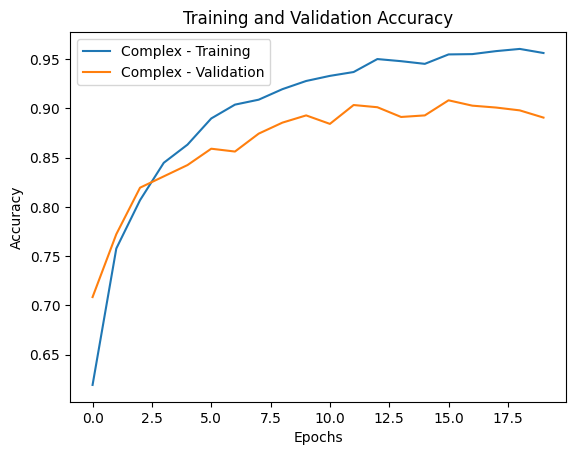

In [36]:
# Plot training and validation accuracy
plt.plot(history_complex.history['accuracy'], label='Complex - Training')
plt.plot(history_complex.history['val_accuracy'], label='Complex - Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# 4. Inference

In [37]:
def process_audio(path , sr=16000):
  audio, sr = librosa.load(path, sr=sr)
  mfccs = librosa.feature.mfcc(y=audio , sr=16000 , n_mfcc=12 , n_fft=512, hop_length=82)
  return mfccs.T

In [38]:
def identify_speaker(mfccs):
  prediction = model_complex.predict(mfccs_15)
  speaker_ids = np.argmax(prediction , axis=1)
  counts = np.bincount(speaker_ids)
  speaker_id = np.argmax(counts)
  print(f"The speaker is : {speaker_names[speaker_id]}")
  return counts , speaker_id

In [39]:
print(speaker_names)

['Speaker0040', 'Speaker0046', 'Speaker0047', 'Speaker0050', 'Speaker_0000', 'Speaker_0007', 'Speaker_0008', 'Speaker_0010', 'Speaker_0016', 'Speaker_0017']


In [40]:
test_files = ["/Speaker_0000/Speaker_0000_00017.wav" , "/Speaker_0008/Speaker_0008_00012.wav" , "/Speaker_0008/Speaker_0008_00012.wav"]
for file in test_files:
  file_path = path + "/50_speakers_audio_data" + file
  mfccs_15 = process_audio(file_path)
  counts , speaker_id = identify_speaker(mfccs_15)


367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
The speaker is : Speaker_0000
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
The speaker is : Speaker_0008
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
The speaker is : Speaker_0008


#5. Model Summary and Resources

In [41]:
# Simple parameter count
model_complex.summary()

# Or programmatically
total_params = model_complex.count_params()
trainable_params = sum([tf.keras.backend.count_params(w) for w in model_complex.trainable_weights])
non_trainable_params = sum([tf.keras.backend.count_params(w) for w in model_complex.non_trainable_weights])

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Non-trainable parameters: {non_trainable_params:,}")

# Estimate model size
model_size_mb = (total_params * 4) / (1024 ** 2)  # Assuming float32
print(f"Estimated model size: {model_size_mb:.2f} MB")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 12, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 10, 100)        │           400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 8, 100)         │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 6, 100)         │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 160)            │        96,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 150)            │        24,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 547,262 (2.09 MB)

 Trainable params: 182,420 (712.58 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 364,842 (1.39 MB)

Total parameters: 182,420
Trainable parameters: 182,420
Non-trainable parameters: 0
Estimated model size: 0.70 MB


In [42]:
def count_layer_flops(layer, input_shape, output_shape):
    """
    Calculate FLOPs for a single layer

    Returns FLOPs for forward pass only
    """
    layer_type = layer.__class__.__name__
    flops = 0

    if isinstance(layer, tf.keras.layers.Conv1D):
        # Conv1D FLOPs = 2 * kernel_size * in_channels * out_channels * output_length
        kernel_size = layer.kernel_size[0]
        in_channels = input_shape[-1]
        out_channels = layer.filters
        output_length = output_shape[1] if len(output_shape) > 1 else 1

        # Multiply-accumulate operations
        flops = 2 * kernel_size * in_channels * out_channels * output_length

        # Add bias if present
        if layer.use_bias:
            flops += out_channels * output_length

    elif isinstance(layer, tf.keras.layers.Dense):
        # Dense FLOPs = 2 * input_dim * output_dim
        input_dim = input_shape[-1]
        output_dim = layer.units

        # Matrix multiplication
        flops = 2 * input_dim * output_dim

        # Add bias if present
        if layer.use_bias:
            flops += output_dim

    elif isinstance(layer, tf.keras.layers.Flatten):
        # Flatten has no FLOPs, just reshaping
        flops = 0

    elif isinstance(layer, tf.keras.layers.Activation):
        # Activation functions (ReLU, softmax, etc.)
        # Approximate: 1 FLOP per element
        flops = np.prod(output_shape[1:]) if len(output_shape) > 1 else output_shape[-1]

    elif isinstance(layer, tf.keras.layers.MaxPooling1D) or isinstance(layer, tf.keras.layers.MaxPooling2D):
        # Pooling: comparisons count as operations
        pool_size = layer.pool_size[0] if isinstance(layer.pool_size, tuple) else layer.pool_size
        flops = np.prod(output_shape[1:]) * pool_size

    return flops

In [43]:
def calculate_model_flops(model, input_shape, batch_size=1):
    """
    Calculate FLOPs for forward pass (inference)

    Parameters:
    -----------
    model : tf.keras.Model
        The model to analyze
    input_shape : tuple
        Input shape WITHOUT batch dimension, e.g., (195, 12)
    batch_size : int
        Batch size for inference

    Returns:
    --------
    total_flops : int
        Total FLOPs for one forward pass
    layer_details : list
        Details for each layer
    """

    print("="*80)
    print(f"FORWARD PASS (INFERENCE) FLOPs - Batch Size: {batch_size}")
    print("="*80)

    total_flops = 0
    layer_details = []

    # Create dummy input to trace through model
    dummy_input = tf.random.normal((batch_size,) + input_shape)

    print(f"{'Layer Type':<20} {'Output Shape':<25} {'Params':<15} {'FLOPs':<20}")
    print("-"*80)

    # Get output shape for each layer
    current_shape = (batch_size,) + input_shape

    for layer in model.layers:
        # Get layer output shape
        try:
            layer_output = layer(tf.keras.Input(shape=current_shape[1:]))
            output_shape = layer_output.shape
        except:
            output_shape = layer.output_shape

        # Count FLOPs
        layer_flops = count_layer_flops(layer, current_shape, output_shape)

        # Multiply by batch size
        layer_flops_total = layer_flops * batch_size

        layer_params = layer.count_params()

        layer_info = {
            'name': layer.name,
            'type': layer.__class__.__name__,
            'params': layer_params,
            'flops': layer_flops_total
        }
        layer_details.append(layer_info)

        total_flops += layer_flops_total

        print(f"{layer.__class__.__name__:<20} {str(output_shape):<25} {layer_params:<15,} {layer_flops_total:<20,}")

        current_shape = output_shape

    print("-"*80)
    print(f"{'TOTAL':<20} {'':<25} {model.count_params():<15,} {total_flops:<20,}")
    print("="*80)

    return total_flops, layer_details

In [44]:
def calculate_training_flops(model, input_shape, batch_size, num_epochs, num_samples):
    """
    Estimate FLOPs for training

    Training includes:
    - Forward pass: 1x FLOPs
    - Backward pass: ~2x forward pass FLOPs
    - Weight updates: parameter count

    Parameters:
    -----------
    model : tf.keras.Model
        The model to analyze
    input_shape : tuple
        Input shape without batch dimension
    batch_size : int
        Training batch size
    num_epochs : int
        Number of training epochs
    num_samples : int
        Total number of training samples

    Returns:
    --------
    total_training_flops : int
        Total FLOPs for entire training
    """
    print("\n" + "="*80)
    print("TRAINING FLOPs ESTIMATION")
    print("="*80)

    # Calculate forward pass FLOPs per batch
    forward_flops, _ = calculate_model_flops(model, input_shape, batch_size)

    # Backward pass is approximately 2x forward pass
    backward_flops = 2 * forward_flops

    # Weight update FLOPs (one operation per parameter)
    num_params = model.count_params()
    update_flops = num_params

    # Total FLOPs per batch
    flops_per_batch = forward_flops + backward_flops + update_flops

    # Calculate number of batches
    batches_per_epoch = int(np.ceil(num_samples / batch_size))
    total_batches = batches_per_epoch * num_epochs

    # Total training FLOPs
    total_training_flops = flops_per_batch * total_batches

    print("\n" + "-"*80)
    print("BREAKDOWN:")
    print("-"*80)
    print(f"Forward pass FLOPs (per batch):     {forward_flops:>20,}")
    print(f"Backward pass FLOPs (per batch):    {backward_flops:>20,} (≈2x forward)")
    print(f"Weight update FLOPs (per batch):    {update_flops:>20,}")
    print(f"Total FLOPs per batch:              {flops_per_batch:>20,}")
    print("-"*80)
    print(f"Batches per epoch:                  {batches_per_epoch:>20,}")
    print(f"Total epochs:                       {num_epochs:>20,}")
    print(f"Total batches:                      {total_batches:>20,}")
    print("-"*80)
    print(f"TOTAL TRAINING FLOPs:               {total_training_flops:>20,}")
    print(f"TOTAL TRAINING GFLOPs:              {total_training_flops/1e9:>20,.2f}")
    print(f"TOTAL TRAINING TFLOPs:              {total_training_flops/1e12:>20,.4f}")
    print("="*80)

    return total_training_flops

In [45]:
def compare_training_vs_inference(model, input_shape, batch_size_train, batch_size_inference,
                                   num_epochs, num_train_samples, num_inference_samples=1):
    """
    Compare FLOPs for training vs inference
    """
    print("\n" + "="*80)
    print("TRAINING vs INFERENCE COMPARISON")
    print("="*80)

    # Training FLOPs
    training_flops = calculate_training_flops(
        model, input_shape, batch_size_train, num_epochs, num_train_samples
    )

    # Inference FLOPs (single forward pass)
    inference_flops_per_sample, _ = calculate_model_flops(model, input_shape, batch_size=1)
    total_inference_flops = inference_flops_per_sample * num_inference_samples

    print("\n" + "="*80)
    print("SUMMARY")
    print("="*80)
    print(f"Training FLOPs:                     {training_flops:>20,}")
    print(f"Training GFLOPs:                    {training_flops/1e9:>20,.2f}")
    print(f"Training TFLOPs:                    {training_flops/1e12:>20,.4f}")
    print("-"*80)
    print(f"Inference FLOPs (per sample):       {inference_flops_per_sample:>20,}")
    print(f"Inference FLOPs ({num_inference_samples} samples):     {total_inference_flops:>20,}")
    print(f"Inference GFLOPs:                   {total_inference_flops/1e9:>20,.2f}")
    print("-"*80)
    print(f"Training/Inference ratio:           {training_flops/inference_flops_per_sample:>20,.0f}x")
    print("="*80)

In [46]:
    # Configuration
    input_shape = (12 ,)
    batch_size_train = 64
    batch_size_inference = 195
    num_epochs = 20
    num_train_samples = 15680
    num_test_samples = 3920

    # Calculate inference FLOPs
    inference_flops, layer_details = calculate_model_flops(model_complex, input_shape, batch_size=1)

    # Calculate training FLOPs
    training_flops = calculate_training_flops(
        model_complex, input_shape, batch_size_train, num_epochs, num_train_samples
    )

    # Compare
    compare_training_vs_inference(
        model_complex, input_shape, batch_size_train, batch_size_inference,
        num_epochs, num_train_samples, num_test_samples
    )

FORWARD PASS (INFERENCE) FLOPs - Batch Size: 1
Layer Type           Output Shape              Params          FLOPs               
--------------------------------------------------------------------------------
Reshape              (None, 12, 1)             0               0                   
Conv1D               (None, 10, 100)           400             7,000               
Conv1D               (None, 8, 100)            30,100          480,800             
Conv1D               (None, 6, 100)            30,100          360,600             
Flatten              (None, 600)               0               0                   
Dense                (None, 160)               96,160          192,160             
Dense                (None, 150)               24,150          48,150              
Dense                (None, 10)                1,510           3,010               
--------------------------------------------------------------------------------
TOTAL                              

#6. Booleanization of features

## Quantile-Based Binning

In [49]:
class QuantileBooleanizer:
    """
    Quantile-based Booleanization for MFCC features

    This converts MFCC features
    to Boolean representations using adaptive quantile-based binning.
    """

    def __init__(self, n_bins: int = 2):
        """
        Initialize Quantile Booleanizer

        Args:
            n_bins: Number of quantile bins (default: 2 for 50% quantile method)
                   - 2 bins = 1 Boolean per feature
                   - 4 bins = 2 Booleans per feature
                   - 10 bins = 4 Booleans per feature (as shown in Table 1)
        """
        self.n_bins = n_bins
        self.n_bits = int(np.ceil(np.log2(n_bins))) if n_bins > 2 else 1
        self.quantiles = None
        self.is_fitted = False

        print(f"Quantile Booleanizer initialized:")
        print(f"  Number of bins: {self.n_bins}")
        print(f"  Bits per feature: {self.n_bits}")

    def fit(self, features: np.ndarray) -> 'QuantileBooleanizer':
        """
        Fit the quantile thresholds based on training data

        As described in the paper: "Through binning the data using its own
        distribution, we maintain their statistical properties and do not
        need to provide bin boundaries, merely the number of bins."

        Args:
            features: Training features of shape (n_samples, n_features)

        Returns:
            self
        """
        if len(features.shape) == 1:
            features = features.reshape(-1, 1)

        n_features = features.shape[1]

        # Calculate quantile boundaries for each feature
        # Shape: (n_features, n_bins-1) for the bin edges
        self.quantiles = np.zeros((n_features, self.n_bins - 1))

        for i in range(n_features):
            feature_values = features[:, i]

            # Calculate quantile boundaries
            # For 2 bins: 50th percentile (median)
            # For 4 bins: 25th, 50th, 75th percentiles
            # For 10 bins: 10th, 20th, ..., 90th percentiles
            quantile_points = np.linspace(0, 100, self.n_bins + 1)[1:-1]
            self.quantiles[i] = np.percentile(feature_values, quantile_points)

        self.is_fitted = True
        print(f"Fitted quantiles for {n_features} features")

        return self

    def transform(self, features: np.ndarray) -> np.ndarray:
        """
        Transform features to Boolean representation using quantile binning

        From the paper (Figure 4): Features are discretized based on which
        quantile bin they fall into, then converted to Boolean representation.

        Args:
            features: Features to transform of shape (n_samples, n_features) or (n_features,)

        Returns:
            Boolean features (0s and 1s)
        """
        if not self.is_fitted:
            raise ValueError("Booleanizer must be fitted before transform")

        is_single_sample = len(features.shape) == 1
        if is_single_sample:
            features = features.reshape(1, -1)

        n_samples, n_features = features.shape

        # Initialize Boolean feature array
        if self.n_bins == 2:
            # For 2 bins, use simple 1 bit per feature
            boolean_features = np.zeros((n_samples, n_features), dtype=np.uint8)

            for i in range(n_features):
                # Values above median (50th percentile) = 1, below = 0
                boolean_features[:, i] = (features[:, i] > self.quantiles[i, 0]).astype(np.uint8)
        else:
            # For more bins, digitize into bins then convert to binary representation
            boolean_features = np.zeros((n_samples, n_features * self.n_bits), dtype=np.uint8)

            for i in range(n_features):
                # Digitize: assign each value to a bin (0 to n_bins-1)
                bin_indices = np.digitize(features[:, i], self.quantiles[i])

                # Convert bin index to binary representation
                for bit in range(self.n_bits):
                    boolean_features[:, i * self.n_bits + bit] = (bin_indices >> bit) & 1

        if is_single_sample:
            boolean_features = boolean_features.flatten()

        return boolean_features

    def fit_transform(self, features: np.ndarray) -> np.ndarray:
        """
        Fit quantiles and transform features in one step

        Args:
            features: Features to fit and transform

        Returns:
            Boolean features
        """
        self.fit(features)
        return self.transform(features)

In [50]:
# Parameters
frames_per_file = 196
files_per_speaker = 10
frames_per_speaker = frames_per_file * files_per_speaker
n_speakers = 10

# Prepare empty lists for splits
X_train_list, X_test_list = [], []
y_train_list, y_test_list = [], []

# Loop over speakers
for spk in range(n_speakers):
    start = spk * frames_per_speaker
    end = (spk + 1) * frames_per_speaker

    # Extract frames for this speaker
    X_speaker = X_frames[start:end]
    y_speaker = y_frames[start:end]

    # Split per-file basis: 10 files × 196 frames each
    for file_idx in range(files_per_speaker):
        file_start = file_idx * frames_per_file
        file_end = (file_idx + 1) * frames_per_file

        if file_idx < 8:  # first 8 files (≈80%)
            X_train_list.append(X_speaker[file_start:file_end])
            y_train_list.append(y_speaker[file_start:file_end])
        else:              # last 2 files (≈20%)
            X_test_list.append(X_speaker[file_start:file_end])
            y_test_list.append(y_speaker[file_start:file_end])

# Combine all speakers
X_train = np.vstack(X_train_list)
y_train = np.hstack(y_train_list)
X_test = np.vstack(X_test_list)
y_test = np.hstack(y_test_list)

print("Train:", X_train.shape, y_train.shape)
print("Test:", X_test.shape, y_test.shape)

Train: (15680, 12) (15680,)
Test: (3920, 12) (3920,)


### 2 Bins:

In [51]:
qb = QuantileBooleanizer(n_bins=2)
qb.fit(X_train)

Quantile Booleanizer initialized:
  Number of bins: 2
  Bits per feature: 1
Fitted quantiles for 12 features


In [52]:
X_train_bool = qb.transform(X_train)
X_test_bool = qb.transform(X_test)

In [53]:
print(X_train_bool.shape)
print(X_test_bool.shape)
print(y_train.shape)
print(y_test.shape)

(15680, 12)
(3920, 12)
(15680,)
(3920,)


In [54]:
train_df = pd.DataFrame(X_train_bool)
train_df['label'] = y_train
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
train_df['split'] = 'train'

test_df = pd.DataFrame(X_test_bool)
test_df['label'] = y_test
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df['split'] = 'test'

combined_df = pd.concat([train_df, test_df], ignore_index=True)
combined_df.to_csv('mfcc_booleanized.csv', index=False)

In [55]:
qb_test = QuantileBooleanizer(n_bins=2)
qb_test.fit(X_frames_testing)
X_frames_testing_bool = qb.transform(X_frames_testing)

Quantile Booleanizer initialized:
  Number of bins: 2
  Bits per feature: 1
Fitted quantiles for 12 features


In [56]:
testing_df = pd.DataFrame(X_frames_testing_bool)
testing_df['label'] = y_frames_testing

testing_df.to_csv('mfcc_booleanized_testing.csv', index=False)

### 4 Bins:

In [63]:
qb_4 = QuantileBooleanizer(n_bins=4)
qb_4.fit(X_train)

Quantile Booleanizer initialized:
  Number of bins: 4
  Bits per feature: 2
Fitted quantiles for 12 features


In [65]:
X_train_bool_4 = qb_4.transform(X_train)
X_test_bool_4 = qb_4.transform(X_test)

In [66]:
print(X_train_bool_4.shape)
print(X_test_bool_4.shape)
print(y_train.shape)
print(y_test.shape)

(15680, 24)
(3920, 24)
(15680,)
(3920,)


In [67]:
train_df_4 = pd.DataFrame(X_train_bool_4)
train_df_4['label'] = y_train
train_df_4 = train_df_4.sample(frac=1, random_state=42).reset_index(drop=True)
train_df_4['split'] = 'train'

test_df_4 = pd.DataFrame(X_test_bool_4)
test_df_4['label'] = y_test
test_df_4 = test_df_4.sample(frac=1, random_state=42).reset_index(drop=True)
test_df_4['split'] = 'test'

combined_df_4 = pd.concat([train_df_4, test_df_4], ignore_index=True)
combined_df_4.to_csv('mfcc_booleanized_4.csv', index=False)

In [68]:
qb_test_4 = QuantileBooleanizer(n_bins=4)
qb_test_4.fit(X_frames_testing)
X_frames_testing_bool_4 = qb_test_4.transform(X_frames_testing)

Quantile Booleanizer initialized:
  Number of bins: 4
  Bits per feature: 2
Fitted quantiles for 12 features


In [69]:
testing_df_4 = pd.DataFrame(X_frames_testing_bool_4)
testing_df_4['label'] = y_frames_testing

testing_df_4.to_csv('mfcc_booleanized_testing_4.csv', index=False)

### 8 bins:

In [70]:
qb_8 = QuantileBooleanizer(n_bins=8)
qb_8.fit(X_train)

Quantile Booleanizer initialized:
  Number of bins: 8
  Bits per feature: 3
Fitted quantiles for 12 features


In [71]:
X_train_bool_8 = qb_8.transform(X_train)
X_test_bool_8 = qb_8.transform(X_test)

In [72]:
print(X_train_bool_8.shape)
print(X_test_bool_8.shape)
print(y_train.shape)
print(y_test.shape)

(15680, 36)
(3920, 36)
(15680,)
(3920,)


In [73]:
train_df_8 = pd.DataFrame(X_train_bool_8)
train_df_8['label'] = y_train
train_df_8 = train_df_8.sample(frac=1, random_state=42).reset_index(drop=True)
train_df_8['split'] = 'train'

test_df_8 = pd.DataFrame(X_test_bool_8)
test_df_8['label'] = y_test
test_df_8 = test_df_8.sample(frac=1, random_state=42).reset_index(drop=True)
test_df_8['split'] = 'test'

combined_df_8 = pd.concat([train_df_8, test_df_8], ignore_index=True)
combined_df_8.to_csv('mfcc_booleanized_8.csv', index=False)

In [74]:
qb_test_8 = QuantileBooleanizer(n_bins=8)
qb_test_8.fit(X_frames_testing)
X_frames_testing_bool_8 = qb_test_8.transform(X_frames_testing)

Quantile Booleanizer initialized:
  Number of bins: 8
  Bits per feature: 3
Fitted quantiles for 12 features


In [75]:
testing_df_8 = pd.DataFrame(X_frames_testing_bool_8)
testing_df_8['label'] = y_frames_testing

testing_df_8.to_csv('mfcc_booleanized_testing_8.csv', index=False)